# **Domain-specific Dataset Expolration (Legal Citation Text Classification)**

## **Importing Libraries**

In [1]:
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

## **Loading Dataset**

In [2]:
df =pd.read_csv (r"C:\Users\bbuser\Desktop\legal_text_classification.csv")
df

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...
...,...,...,...,...
24980,Case25203,cited,Reches Pty Ltd v Tadiran Pty Ltd (1998) 85 FCR...,That is not confined to persons who control th...
24981,Case25204,cited,Sir Lindsay Parkinson &amp; Co Ltd v Triplan L...,Once the threshold prescribed by s 1335 is sat...
24982,Case25205,cited,Spiel v Commodity Brokers Australia Pty Ltd (I...,Once the threshold prescribed by s 1335 is sat...
24983,Case25206,distinguished,"Tullock Ltd v Walker (Unreported, Supreme Cour...",Given the extent to which Deumer stands to gai...


In [3]:
df.shape

(24985, 4)

In [4]:
df.columns

Index(['case_id', 'case_outcome', 'case_title', 'case_text'], dtype='object')

In [5]:
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


## **EDA**

In [6]:
# Check for missing values
df.isnull().sum()

case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

In [7]:
# Drop rows missing text or outcome
df = df.dropna(subset=['case_text', 'case_outcome'])

In [8]:
# Basic info about target classes
print("\nClass distribution:")
print(df['case_outcome'].value_counts())


Class distribution:
case_outcome
cited            12110
referred to       4363
applied           2438
followed          2252
considered        1699
discussed         1018
distinguished      603
related            112
approved           108
affirmed           106
Name: count, dtype: int64


In [9]:
# Simple text length analysis
df['text_length'] = df['case_text'].apply(lambda x: len(str(x).split()))
print("\nAverage text length:", df['text_length'].mean())


Average text length: 454.9097908017252


C:\Users\bbuser\AppData\Local\Temp\ipykernel_7504\2842369191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['case_text'].apply(lambda x: len(str(x).split()))


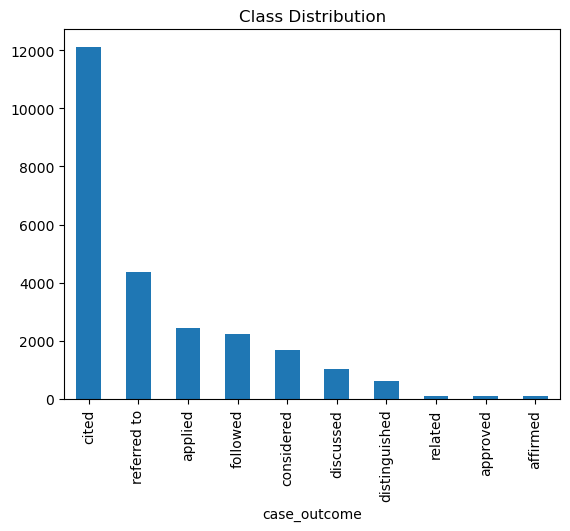

In [10]:
# Visualize class distribution (optional)
import matplotlib.pyplot as plt
df['case_outcome'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

## **Text preprocessing**

In [11]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                            # lowercase
    text = re.sub(r'[^a-z\s]', '', text)           # remove punctuation and numbers
    text = ' '.join([w for w in text.split() if w not in stop_words])  # remove stopwords
    return text

df['clean_text'] = df['case_text'].apply(clean_text)
df[['case_text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\bbuser\AppData\Local\Temp\ipykernel_7504\2122747182.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['case_text'].apply(clean_text)


,case_text,clean_text
0,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised costs follow e...
1,The general principles governing the exercise ...,general principles governing exercise discreti...
2,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised costs follow e...
3,The general principles governing the exercise ...,general principles governing exercise discreti...
4,The preceding general principles inform the ex...,preceding general principles inform exercise d...


## **Vectorize text with TF-IDF**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=3)
X = tfidf.fit_transform(df['clean_text'])
y = df['case_outcome'].values

print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (24809, 50000)


## **Split into train / validation / test**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train / validation / test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])
print("Classes:", le.classes_)

Train size: 17366
Validation size: 3721
Test size: 3722
Classes: ['affirmed' 'applied' 'approved' 'cited' 'considered' 'discussed'
 'distinguished' 'followed' 'referred to' 'related']


## **Train a classical model (Logistic Regression)**

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import time

clf = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1)

t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()

train_time_clf = t1 - t0
print(f"Training time (Logistic Regression): {train_time_clf:.2f}s")

# Evaluate performance
y_pred_test = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test, target_names=le.classes_, zero_division=0))

Training time (Logistic Regression): 38.96s
Test Accuracy: 0.5591
Precision: 0.5714, Recall: 0.5591, F1: 0.4727

Classification Report:
                precision    recall  f1-score   support

     affirmed       0.75      0.38      0.50        16
      applied       0.48      0.12      0.19       366
     approved       0.00      0.00      0.00        16
        cited       0.55      0.95      0.70      1817
   considered       0.46      0.05      0.09       255
    discussed       0.55      0.04      0.07       152
distinguished       1.00      0.01      0.02        90
     followed       0.66      0.12      0.21       338
  referred to       0.62      0.37      0.46       655
      related       1.00      0.06      0.11        17

     accuracy                           0.56      3722
    macro avg       0.61      0.21      0.24      3722
 weighted avg       0.57      0.56      0.47      3722



## **Train Neural Network (Feed-forward MLP with TruncatedSVD)**

In [15]:
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Dimensionality reduction (TF-IDF → 300 components)
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)
X_test_svd = svd.transform(X_test)

print("Reduced feature shape:", X_train_svd.shape)

# Define simple MLP model
num_classes = len(le.classes_)

def build_mlp(input_dim, num_classes):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    if num_classes == 2:
        model.add(layers.Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model

mlp = build_mlp(X_train_svd.shape[1], num_classes)
mlp.summary()

# Train model with early stopping
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

t0 = time.time()
history = mlp.fit(X_train_svd, y_train,
                  validation_data=(X_val_svd, y_val),
                  epochs=20, batch_size=64,
                  callbacks=[es], verbose=2)
t1 = time.time()

train_time_nn = t1 - t0
print(f"Training time (Neural Net): {train_time_nn:.2f}s")

# Evaluate on test
if num_classes == 2:
    preds = (mlp.predict(X_test_svd) > 0.5).astype(int)
else:
    preds = mlp.predict(X_test_svd).argmax(axis=1)

acc_nn = accuracy_score(y_test, preds)
prec_nn, rec_nn, f1_nn, _ = precision_recall_fscore_support(y_test, preds, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_nn:.4f}")
print(f"Precision: {prec_nn:.4f}, Recall: {rec_nn:.4f}, F1: {f1_nn:.4f}")

Reduced feature shape: (17366, 300)


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,242 (434.54 KB)

 Trainable params: 111,242 (434.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
272/272 - 9s - 32ms/step - accuracy: 0.4832 - loss: 1.6151 - val_accuracy: 0.4899 - val_loss: 1.5093
Epoch 2/20
272/272 - 4s - 15ms/step - accuracy: 0.4976 - loss: 1.4695 - val_accuracy: 0.4996 - val_loss: 1.4540
Epoch 3/20
272/272 - 5s - 19ms/step - accuracy: 0.5077 - loss: 1.4072 - val_accuracy: 0.5063 - val_loss: 1.4331
Epoch 4/20
272/272 - 5s - 20ms/step - accuracy: 0.5168 - loss: 1.3614 - val_accuracy: 0.5069 - val_loss: 1.4123
Epoch 5/20
272/272 - 5s - 19ms/step - accuracy: 0.5307 - loss: 1.3125 - val_accuracy: 0.5141 - val_loss: 1.3921
Epoch 6/20
272/272 - 5s - 20ms/step - accuracy: 0.5443 - loss: 1.2672 - val_accuracy: 0.5138 - val_loss: 1.3872
Epoch 7/20
272/272 - 4s - 14ms/step - accuracy: 0.5627 - loss: 1.2229 - val_accuracy: 0.5251 - val_loss: 1.3653
Epoch 8/20
272/272 - 5s - 20ms/step - accuracy: 0.5785 - loss: 1.1761 - val_accuracy: 0.5318 - val_loss: 1.3496
Epoch 9/20
272/272 - 4s - 14ms/step - accuracy: 0.5955 - loss: 1.1351 - val_accuracy: 0.5251 - val_loss:

## **Compare Results & Discuss**

In [16]:
print("\n===== SUMMARY =====")
print(f"Logistic Regression -> Accuracy: {acc:.4f}, F1: {f1:.4f}, Training time: {train_time_clf:.2f}s")
print(f"Neural Network      -> Accuracy: {acc_nn:.4f}, F1: {f1_nn:.4f}, Training time: {train_time_nn:.2f}s")

if acc > acc_nn:
    print("\nClassical ML performed better.")
else:
    print("\nNeural Network performed better.")

print("""
📝 Reflection:
- Logistic Regression trains faster because it’s a convex optimization problem with fewer parameters.
- The Neural Network needs dimensionality reduction and more computation time.
- If the dataset is small, classical ML often generalizes better.
- With more data or deeper architectures, NNs might surpass classical ML.
""")


===== SUMMARY =====
Logistic Regression -> Accuracy: 0.5591, F1: 0.4727, Training time: 38.96s
Neural Network      -> Accuracy: 0.5422, F1: 0.5031, Training time: 71.81s

Classical ML performed better.

📝 Reflection:
- Logistic Regression trains faster because it’s a convex optimization problem with fewer parameters.
- The Neural Network needs dimensionality reduction and more computation time.
- If the dataset is small, classical ML often generalizes better.
- With more data or deeper architectures, NNs might surpass classical ML.

